In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import json
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import collections
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import GridSearchCV
import datetime, time
import pytz
import statsmodels.api as stats_api
import pickle as pickle_
import csv

/Users/satya/Anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Popularity Prediction

#### Initialize variables

In [2]:
hashtags = ['#gopatriots','#nfl','#sb49','#gohawks','#patriots','#superbowl'] #using only one tag
#hashtags = ['#sb49','#gohawks','#patriots','#superbowl'] #using only one tag
df_map = {} # to store dfs for each file

#### Reading files into dataframes and storing

In [3]:
import os
df_columns = ['timestamp','tweet_id','author_id','followers','retweets','title','location']
bypass = False
for hashtag in hashtags:
    df = pd.DataFrame(columns=df_columns)
    lno = 0
    print("Processing ",hashtag)
    with open("tweet_data/tweets_"+hashtag+".txt", "r") as file_obj:
        if(not os.path.isfile('temp/'+hashtag+'.csv') or bypass):
            writer=csv.writer(open('temp/'+hashtag+'.csv','w'))
            writer.writerow(df_columns)
            line = file_obj.readline()
            while(line):
                if(lno%20000 == 0):
                    print(lno)
                j = json.loads(line)
                lno+=1
                timestamp =j['citation_date']
                followers =j['author']['followers']
                retweets = j['metrics']['citations']['total']
                author_id = j['author']['url']
                tweet_id = j['tweet']['id']
                title = j['title']
                location=j['tweet']['user']['location']
                writer.writerow([timestamp,tweet_id,author_id,followers,retweets,title,location])
                line = file_obj.readline()
        else:
            print("File Exists!")
            #writer.close()

Processing  #gopatriots
File Exists!
Processing  #nfl
File Exists!
Processing  #sb49
File Exists!
Processing  #gohawks
File Exists!
Processing  #patriots
File Exists!
Processing  #superbowl
File Exists!


In [4]:
df_map = {}

In [5]:
for hashtag in hashtags:
    print('loaded dataframe',hashtag)
    df_map[hashtag] = pd.read_csv('temp/'+hashtag+'.csv')


loaded dataframe #gopatriots
loaded dataframe #nfl
loaded dataframe #sb49
loaded dataframe #gohawks
loaded dataframe #patriots
loaded dataframe #superbowl


## 1.1 Statistics

In [6]:
for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag]
    print(df.count())

#gopatriots
timestamp    26232
tweet_id     26232
author_id    26232
followers    26232
retweets     26232
title        26232
location     17486
dtype: int64
#nfl
timestamp    259024
tweet_id     259024
author_id    259024
followers    259024
retweets     259024
title        259024
location     184522
dtype: int64
#sb49
timestamp    826951
tweet_id     826951
author_id    826951
followers    826951
retweets     826951
title        826951
location     465648
dtype: int64
#gohawks
timestamp    188136
tweet_id     188136
author_id    188136
followers    188136
retweets     188136
title        188136
location     136453
dtype: int64
#patriots
timestamp    489713
tweet_id     489713
author_id    489713
followers    489713
retweets     489713
title        489713
location     292030
dtype: int64
#superbowl
timestamp    1348761
tweet_id     1348761
author_id    1348761
followers    1348761
retweets     1348761
title        1348761
location      989492
dtype: int64


In [37]:
tweets_hrly = {}
retweets_avg = {}
followers_hrly = {}
tweets_cnt = {}
retweets_cnt = {}
followers_cnt = {}

for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag]
    sec = df['timestamp'].max() - df['timestamp'].min()   
    tweets_cnt[hashtag] = df['tweet_id'].count()
    retweets_cnt[hashtag] = df['retweets'].sum()
    followers_cnt[hashtag] = df['followers'].sum()
    tweets_hrly[hashtag] = (tweets_cnt[hashtag]*3600)/sec
    retweets_avg[hashtag] = (retweets_cnt[hashtag])/tweets_cnt[hashtag]
    followers_hrly[hashtag] = (followers_cnt[hashtag]*3600)/sec    


#gopatriots
#nfl
#sb49
#gohawks
#patriots
#superbowl


In [38]:
print('Tweets Count : ',tweets_cnt)
print('Tweets Avg. hourly',tweets_hrly)
print('Retweets Count : ',retweets_cnt)
print('Retweets Avg. hourly',retweets_avg)

print('Followers Count : ',followers_cnt)
print('Followers Avg. hourly',followers_cnt)

Tweets Count :  {'#gopatriots': 26232, '#nfl': 259024, '#sb49': 826951, '#gohawks': 188136, '#patriots': 489713, '#superbowl': 1348761}
Tweets Avg. hourly {'#gopatriots': 45.694510573562027, '#nfl': 441.3234311373958, '#sb49': 1419.8879074871904, '#gohawks': 325.3715913043311, '#patriots': 834.55550916418849, '#superbowl': 2309.9309809384081}
Retweets Count :  {'#gopatriots': 36727, '#nfl': 398517, '#sb49': 2076597, '#gohawks': 379022, '#patriots': 873068, '#superbowl': 3221210}
Retweets Avg. hourly {'#gopatriots': 1.4000838670326319, '#nfl': 1.5385331089011056, '#sb49': 2.5111487863247035, '#gohawks': 2.014617085512608, '#patriots': 1.7828156491659402, '#superbowl': 2.3882733857221554}
Followers Count :  {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots': 1620939662.0, '#superbowl': 11948576274.0}
Followers Avg. hourly {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots'

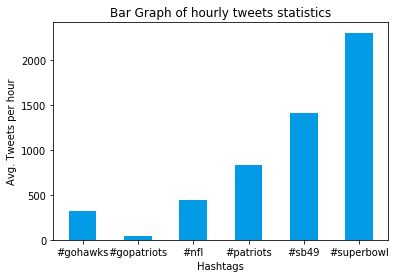

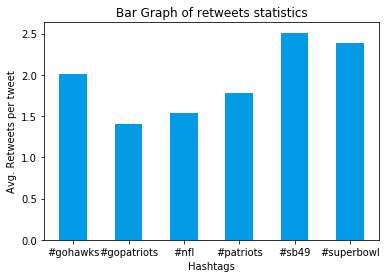

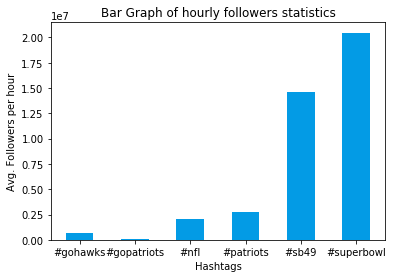

In [40]:
plt.bar(tweets_hrly.keys(),tweets_hrly.values(), width=0.5, color='#039BE5')
plt.title('Bar Graph of hourly tweets statistics')
plt.xlabel('Hashtags')
plt.ylabel('Avg. Tweets per hour')
plt.show()
plt.bar(retweets_avg.keys(),retweets_avg.values(), width=0.5, color='#039BE5')
plt.title('Bar Graph of retweets statistics')
plt.xlabel('Hashtags')
plt.ylabel('Avg. Retweets per tweet')
plt.show()
plt.bar(followers_hrly.keys(),followers_hrly.values(), width=0.5, color='#039BE5')
plt.title('Bar Graph of hourly followers statistics')
plt.xlabel('Hashtags')
plt.ylabel('Avg. Followers per hour')
plt.show()

#### Returns the hour number from timestamp

In [7]:
pst_tz = pytz.timezone('US/Mountain')
def getHourofDay(timestamp):
    #print(timestamp)
    return datetime.datetime.fromtimestamp(timestamp, pst_tz).hour

    
def getHour(timestamp):
    return int(timestamp/3600)

#gopatriots
   timestamp  tweet_id
0     394785         1
447
#nfl
   timestamp  tweet_id
0     394784        59
583
#sb49
   timestamp  tweet_id
0     394788         1
541
#gohawks
   timestamp  tweet_id
0     394784        30
572
#patriots
   timestamp  tweet_id
0     394784        23
587
#superbowl
   timestamp  tweet_id
0     394784         8
585


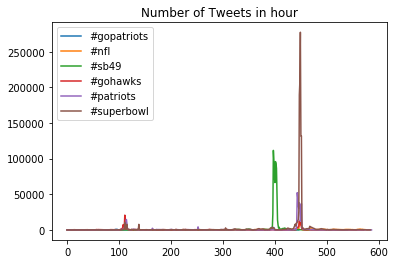

In [16]:
for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
    grouped = df.groupby('timestamp').agg({'tweet_id':'count'})
    #grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    #grouped.columns=grouped.columns.droplevel()
    grouped.reset_index(inplace=True)
    print(grouped.head(1))
    plt.plot(list(grouped['tweet_id']),label=hashtag)
    plt.title('Number of Tweets in hour')
    print(len(list(grouped['tweet_id'])))
plt.legend()
plt.show()


## 1.2 Linear Regression

In [49]:
X_map = {}
Y_map = {}
for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
    grouped = df.groupby('timestamp').agg({'followers': ['sum', 'max'],'tweet_id':'count', 'retweets':'sum'})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    #grouped.columns=grouped.columns.droplevel()
    grouped.reset_index(inplace=True)
    grouped['hour_of_day'] = grouped.apply(lambda x: getHourofDay(x['timestamp']*3600), axis=1)
    X_map[hashtag] = grouped.drop(['timestamp'],axis=1)
    print(grouped.head(2))
    Y_map[hashtag] = grouped['tweet_id_count']
    #print(grouped)
    

#gopatriots
   timestamp  followers_sum  followers_max  tweet_id_count  retweets_sum  \
0     394785        10955.0        10955.0               1             4   
1     394786         1762.0         1762.0               1             3   

   hour_of_day  
0            2  
1            3  
#nfl
   timestamp  followers_sum  followers_max  tweet_id_count  retweets_sum  \
0     394784       104976.0        10658.0              59            67   
1     394785       107645.0        17117.0              54           193   

   hour_of_day  
0            1  
1            2  
#sb49
   timestamp  followers_sum  followers_max  tweet_id_count  retweets_sum  \
0     394788           59.0           59.0               1             2   
1     394790           74.0           53.0               2             2   

   hour_of_day  
0            5  
1            7  
#gohawks
   timestamp  followers_sum  followers_max  tweet_id_count  retweets_sum  \
0     394784        24989.0        12922.0          

#### Method to merge n prev hours

In [54]:
#n : number of hours you want to merge
#f : features in each row
#x : X_map value
#y : Y_map value
def getprev_n_merged(n,f,X,y):
    print(X.head(1))
    X = X.as_matrix()
    X_new = []
    rnew = []
    for row in X[:n]:
        rnew = rnew + list(row)
    
    X_new.append(rnew)
    for row in X[n:]:
        rnew = rnew[f:]+list(row)
        X_new.append(rnew)
    return X_new[:-1],list(y)[n:]

In [56]:
x,y= getprev_n_merged(2,5,X_map['#gopatriots'],Y_map['#gopatriots'])

   followers_sum  followers_max  tweet_id_count  retweets_sum  hour_of_day
0        10955.0        10955.0               1             4            2


In [58]:
X_map['#gopatriots'].head()

,followers_sum,followers_max,tweet_id_count,retweets_sum,hour_of_day
0,10955.0,10955.0,1,4,2
1,1762.0,1762.0,1,3,3
2,1168.0,600.0,2,3,5
3,465.0,431.0,2,3,6
4,2850.0,1425.0,2,3,7


In [24]:
for hashtag in hashtags:
    print(hashtag)
    model = stats_api.OLS(Y_map[hashtag].iloc[:-1].as_matrix(),X_map[hashtag].iloc[1:].as_matrix()).fit()
    print(model.summary())
    

#gopatriots
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     364.8
Date:                Thu, 08 Mar 2018   Prob (F-statistic):          1.61e-138
Time:                        14:10:47   Log-Likelihood:                -2919.9
No. Observations:                 446   AIC:                             5848.
Df Residuals:                     442   BIC:                             5864.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0029      0.000    -16.